In [1]:
import cv2
import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import AveragePooling2D, Lambda, Conv2D, Conv2DTranspose, Activation, Reshape, concatenate, Concatenate, BatchNormalization, ZeroPadding2D
print('Tensorflow version =', tf.__version__)

Tensorflow version = 2.0.0-alpha0


## Getting image and mask paths

In [2]:
batch_size = 8
img_height, img_width = 256, 512
image_list = sorted(glob('/home/mia/backup/research/autonomous_driving/cityscapes/dataset/train_images/*'))
mask_list = sorted(glob('/home/mia/backup/research/autonomous_driving/cityscapes/dataset/train_masks/*'))
for i in range(len(image_list)):
    image_list[i].split('/')[-1].split('_leftImg8bit')[0] == mask_list[i].split('/')[-1].split('_gtFine_labelIds')[0]

## Using tf.data to create data input pipeline

In [3]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.cast(tf.image.decode_png(img, channels=3), 'float32')
    img = tf.image.resize(images=img, size=[img_height, img_width])
    img = preprocess_input(img)
    return img

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(tf.image.resize(images=mask, size=[img_height, img_width]), 'uint8')
    return mask

def load_data(image_path, mask_path):
    return load_image(image_path), load_mask(mask_path)

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
ds = ds.map(load_data,num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.cache()
ds = ds.shuffle(512)
ds = ds.batch(batch_size=batch_size)
ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

## Building the DeepLabV3+ model

In [ ]:
def Upsample(tensor, size):
    '''bilinear upsampling'''
    name = tensor.name.split('/')[0] + '_upsample'

    def bilinear_upsample(x, size):
        resized = tf.image.resize(
            images=x, size=size)
        return resized
    y = Lambda(lambda x: bilinear_upsample(x, size),
               output_shape=size, name=name)(tensor)
    return y


def ASPP(tensor):
    '''atrous spatial pyramid pooling'''
    dims = K.int_shape(tensor)

    y_pool = AveragePooling2D(pool_size=(
        dims[1], dims[2]), name='average_pooling')(tensor)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same',
                    kernel_initializer='he_normal', name='pool_1x1conv2d')(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)

    y_pool = Upsample(tensor=y_pool, size=[dims[1], dims[2]])

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
                 kernel_initializer='he_normal', name='ASPP_conv2d_d1')(tensor)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same',
                 kernel_initializer='he_normal', name='ASPP_conv2d_d6')(tensor)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same',
                  kernel_initializer='he_normal', name='ASPP_conv2d_d12')(tensor)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same',
                  kernel_initializer='he_normal', name='ASPP_conv2d_d18')(tensor)
    y_18 = BatchNormalization(name=f'bn_5')(y_18)
    y_18 = Activation('relu', name=f'relu_5')(y_18)

    y = concatenate([y_pool, y_1, y_6, y_12, y_18], name='ASPP_concat')

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
               kernel_initializer='he_normal', name='ASPP_conv2d_final')(y)
    y = BatchNormalization(name=f'bn_final')(y)
    y = Activation('relu', name=f'relu_final')(y)
    return y


def DeepLabV3Plus(img_height, img_width, nclasses=66):
    base_model = ResNet50(input_shape=(
        img_height, img_width, 3), weights='imagenet', include_top=False)
    image_features = base_model.get_layer('activation_39').output
    x_a = ASPP(image_features)
    x_a = Upsample(tensor=x_a, size=[img_height // 4, img_width // 4])

    x_b = base_model.get_layer('activation_9').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same',
                 kernel_initializer='he_normal', name='low_level_projection')(x_b)
    x_b = BatchNormalization(name=f'bn_low_level_projection')(x_b)
    x_b = Activation('relu', name='low_level_activation')(x_b)

    x = concatenate([x_a, x_b], name='decoder_concat')

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
               kernel_initializer='he_normal', name='decoder_conv2d_1')(x)
    x = BatchNormalization(name=f'bn_decoder_1')(x)
    x = Activation('relu', name='activation_decoder_1')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
               kernel_initializer='he_normal', name='decoder_conv2d_2')(x)
    x = BatchNormalization(name=f'bn_decoder_2')(x)
    x = Activation('relu', name='activation_decoder_2')(x)
    x = Upsample(x, [img_height, img_width])

    x = Conv2D(nclasses, (1, 1), name='output_layer')(x)

    model = Model(inputs=base_model.input, outputs=x, name='DeepLabV3_Plus')
    return model

## Defining training loop, loss function and optimizer

In [ ]:
model = DeepLabV3Plus(img_height, img_width, nclasses=34)

loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
train_accuracy = tf.metrics.SparseCategoricalAccuracy()
valid_accuracy = tf.metrics.SparseCategoricalAccuracy()

def loss_function(y_true, y_pred):
    loss = loss_object(y_true, y_pred)
    loss = tf.reduce_mean(loss)
    return loss

@tf.function()
def training_step(image_tensor, mask_tensor):
    with tf.GradientTape() as Tape:
        logits = model(image_tensor, training=True)
        loss = loss_function(mask_tensor, logits)
        acc = train_accuracy(mask_tensor, logits)
    gradients = Tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, acc

@tf.function
def evaluation_step(input_tensor, mask_tensor):
    with tf.GradientTape() as Tape:
        logits = model(input_tensor)
        acc = valid_accuracy(mask_tensor, logits)
    return acc

/home/mia/tensorflow2.0/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


## Training the model
 - Using  tf.keras.utils.Progbar for custom progress bar

In [ ]:
epochs = 50
num_steps = (2975 // batch_size) + 1
loss_array = []
acc_array = []


for epoch in range(1,epochs+1):
    ep_loss = []
    ep_acc = []    
    progbar = tf.keras.utils.Progbar(target=num_steps, stateful_metrics=['curr_loss', 'curr_accuracy'], unit_name='batch')
    print(f'Epoch {epoch}/{epochs}')
    for step, example in enumerate(ds):
        img_tensor = example[0]
        mask_tensor = example[1]
        loss, acc = training_step(img_tensor, mask_tensor)
        loss_array.append(loss)
        ep_loss.append(loss)
        acc_array.append(acc)
        ep_acc.append(acc)
        progbar.update(step+1, values=[('curr_loss', loss), ('curr_accuracy', acc)])
    print(f'Metrics after epoch {epoch} : Loss => {np.mean(ep_loss)} | Accuracy => {np.mean(ep_acc)}')

Epoch 1/50
372/372 [==============================] - 170s 458ms/batch - curr_loss: 0.4404 - curr_accuracy: 0.8221
Metrics after epoch 1 : Loss => 0.6694806814193726 | Accuracy => 0.7701447010040283
Epoch 2/50
372/372 [==============================] - 149s 401ms/batch - curr_loss: 0.3344 - curr_accuracy: 0.8463
Metrics after epoch 2 : Loss => 0.43663322925567627 | Accuracy => 0.8358088731765747
Epoch 3/50
372/372 [==============================] - 149s 400ms/batch - curr_loss: 0.2682 - curr_accuracy: 0.8611
Metrics after epoch 3 : Loss => 0.3622669577598572 | Accuracy => 0.854026198387146
Epoch 4/50
372/372 [==============================] - 140s 378ms/batch - curr_loss: 0.2500 - curr_accuracy: 0.8714
Metrics after epoch 4 : Loss => 0.320581316947937 | Accuracy => 0.8664460778236389
Epoch 5/50
372/372 [==============================] - 140s 377ms/batch - curr_loss: 0.2326 - curr_accuracy: 0.8790
Metrics after epoch 5 : Loss => 0.2920505106449127 | Accuracy => 0.8752424716949463
Epoch 

## Color map to visualize the outputs

In [10]:
id_to_color = {0: (0, 0, 0),
               1: (0, 0, 0),
               2: (0, 0, 0),
               3: (0, 0, 0),
               4: (0, 0, 0),
               5: (111, 74, 0),
               6: (81, 0, 81),
               7: (128, 64, 128),
               8: (244, 35, 232),
               9: (250, 170, 160),
               10: (230, 150, 140),
               11: (70, 70, 70),
               12: (102, 102, 156),
               13: (190, 153, 153),
               14: (180, 165, 180),
               15: (150, 100, 100),
               16: (150, 120, 90),
               17: (153, 153, 153),
               18: (153, 153, 153),
               19: (250, 170, 30),
               20: (220, 220, 0),
               21: (107, 142, 35),
               22: (152, 251, 152),
               23: (70, 130, 180),
               24: (220, 20, 60),
               25: (255, 0, 0),
               26: (0, 0, 142),
               27: (0, 0, 70),
               28: (0, 60, 100),
               29: (0, 0, 90),
               30: (0, 0, 110),
               31: (0, 80, 100),
               32: (0, 0, 230),
               33: (119, 11, 32),
               -1: (0, 0, 142)}

## Visualizing the model performance on validation data

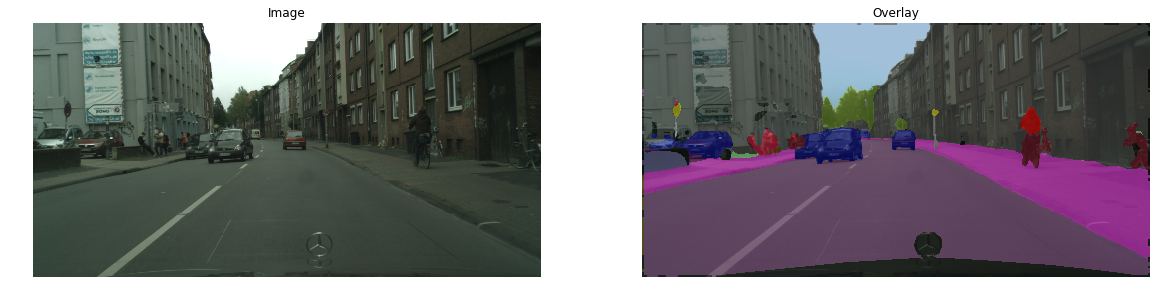

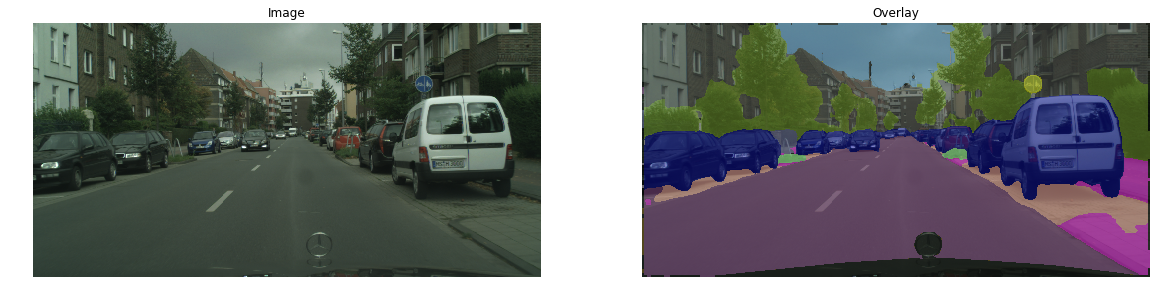

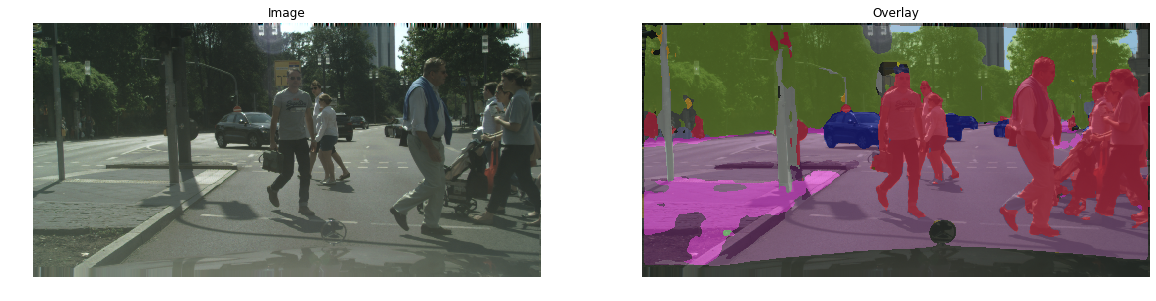

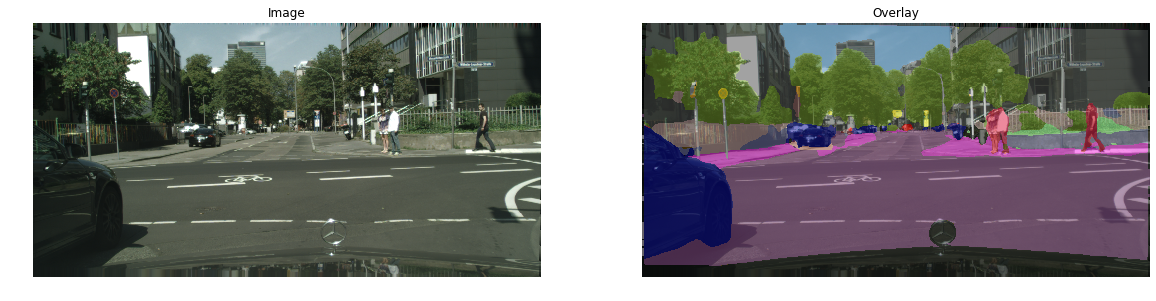

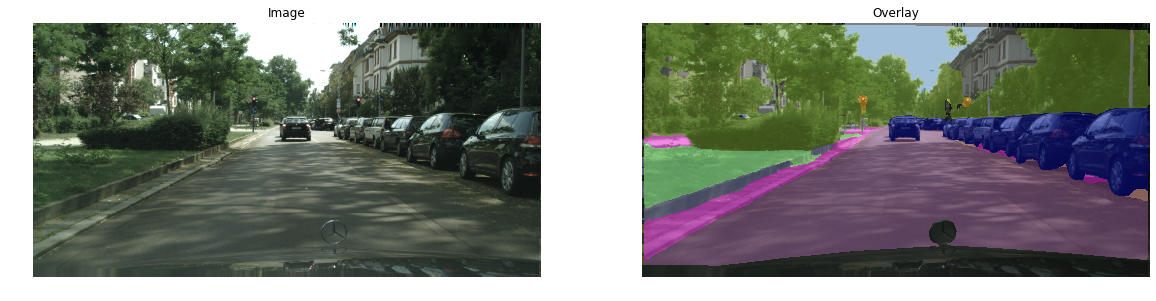

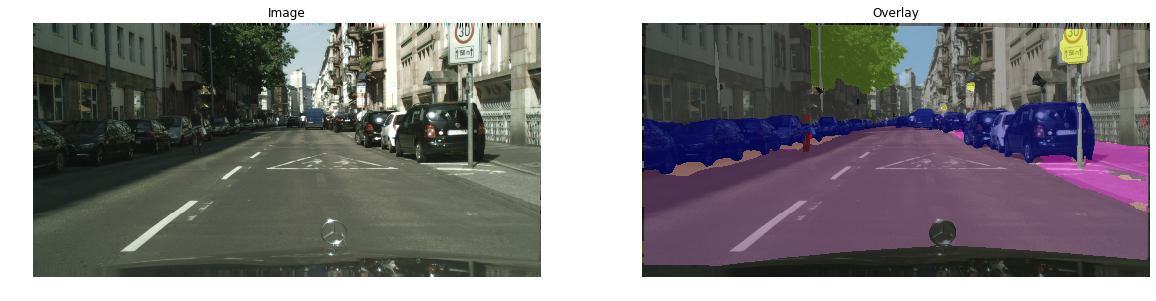

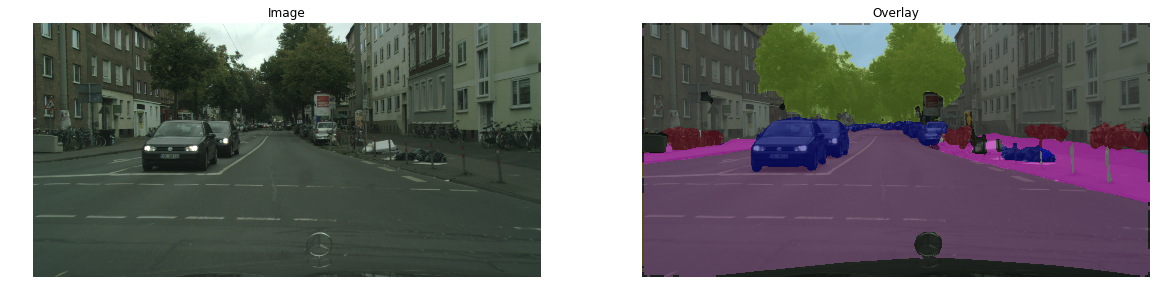

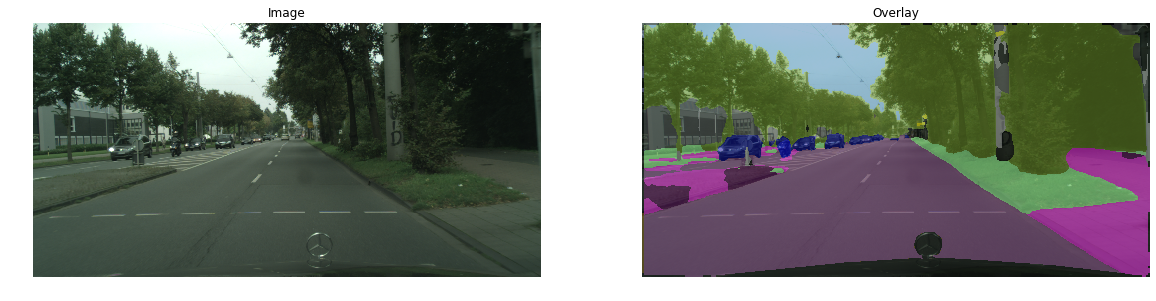

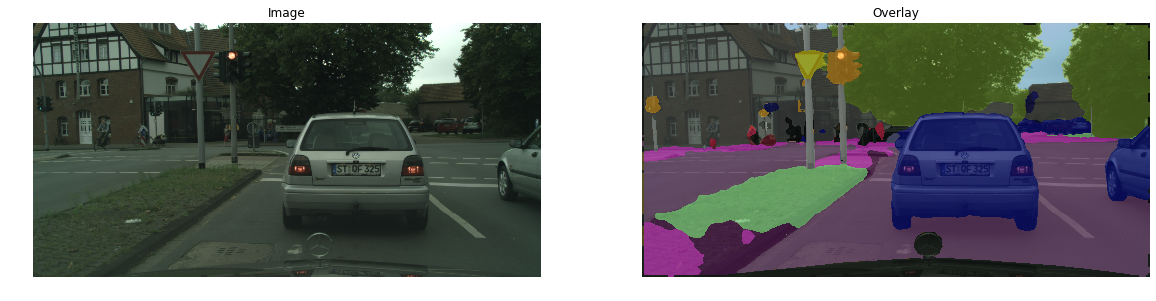

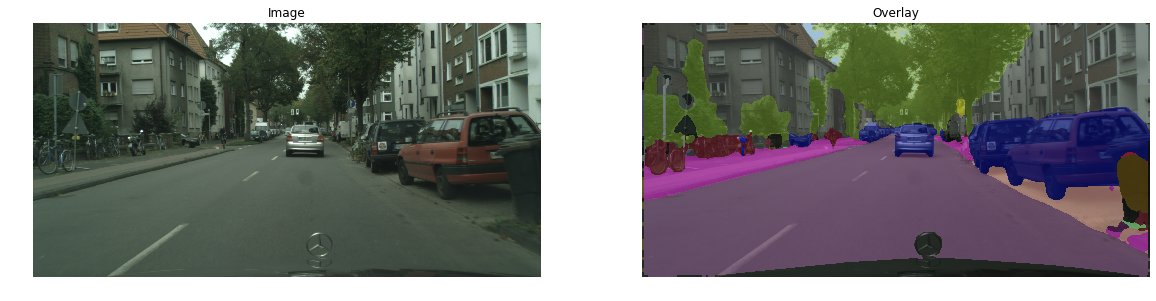

In [13]:
test_images = glob('/home/mia/backup/research/autonomous_driving/cityscapes/dataset/val_images/*')
for idx in np.random.randint(0, len(test_images), 10):
    
    image_path = test_images[idx]
    img = tf.io.read_file(image_path)
    img = tf.cast(tf.image.decode_png(img, channels=3), 'float32')
    img = tf.image.resize(images=img, size=[img_height, img_width]).numpy()
    disp_img = img.copy()    
    img = preprocess_input(img)
    
    img = np.expand_dims(img, axis=0)
    y = model(img)[0]
    y = np.argmax(y, axis=-1)
    
    alpha = 0.5
    img_color = disp_img.copy()   
    for i in np.unique(y):
        if i in id_to_color:
            img_color[y==i] = id_to_color[i]
    disp = img_color.copy()
    cv2.addWeighted(disp_img, alpha, img_color, 1-alpha, 0, img_color)
    
    plt.subplots(1, 2, figsize=(20, 15))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title('Image')
    plt.imshow(disp_img/255.)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title('Overlay')
    plt.imshow(img_color/255.)
